In [494]:
import mujoco
from mujoco import minimize
import numpy as np
import mediapy as media
from pathlib import Path
import quaternion
np.set_printoptions(precision=3, suppress=True, linewidth=100)


## Setup
- models/lite6_viz.xml is an edited version of the lite6 model from mujoco_menagerie. Most crucially, a "target" body is added to visualise the target frame.
- In models/lite6_viz.xml, change the meshdir in line 2 to point to wherever mujoco_menagerie is cloned, to load the assets

In [260]:
# Load model XML

# robot_descriptions doesn't include ufactory lite 6, so we laod the XML from menagerie
# Also, there are a couple of edits needed to make to the deafult scene, so we make them in a file there
scene_path = "models/lite6_viz.xml"
model = mujoco.MjModel.from_xml_path(scene_path)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)


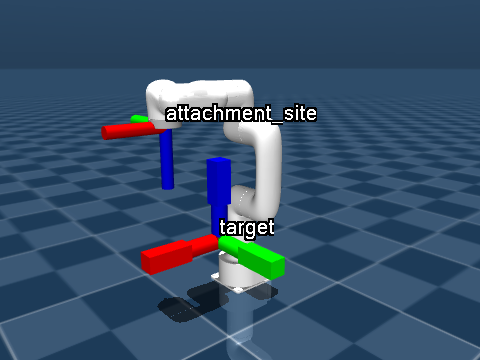

In [113]:
# Initial model visualisation and parameter setup
mujoco.mj_resetDataKeyframe(model, data, 0)
mujoco.mj_forward(model, data)

# Make a Renderer and a camera.
renderer = mujoco.Renderer(model, height=360, width=480)
camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 1.2
camera.elevation = -15
camera.azimuth = -130
camera.lookat = (0, 0, 0.3)

# Visualize site frames and labels
voption = mujoco.MjvOption()
voption.frame = mujoco.mjtFrame.mjFRAME_SITE
voption.label = mujoco.mjtLabel.mjLABEL_SITE
renderer.update_scene(data, camera, scene_option=voption)
voption.label = mujoco.mjtLabel.mjLABEL_NONE

media.show_image(renderer.render())


In [263]:
# Joint ranges if you're interested
print(f"Joint ranges:\n{model.jnt_range}")
bounds = [model.jnt_range[:, 0], model.jnt_range[:, 1]]
x0 = model.key(0).qpos

Joint ranges:
[[-6.28319   6.28319 ]
 [-2.61799   2.61799 ]
 [-0.061087  5.23599 ]
 [-6.28319   6.28319 ]
 [-2.1642    2.1642  ]
 [-6.28319   6.28319 ]]


least_squares_solver docs:

```
Nonlinear Least Squares minimization with box bounds.

  Args:
    x0: Initial guess
    residual: Vectorized function returning the residual for 1 or more points.
    bounds: Optional pair of lower and upper bounds on the solution.
    jacobian: Optional function that returns Jacobian of the residual at a given
      point and residual. If not given, `residual` will be finite-differenced.
    norm: Norm object returning norm scalar or its projected gradient and
      Hessian. See Norm class for detailed documentation.
    eps: Perurbation used for automatic finite-differencing.
    mu_min: Minimum value of the regularizer.
    mu_max: Maximum value of the regularizer.
    mu_factor: Factor for increasing or decreasing the regularizer.
    tol: Termination tolerance on the step size.
    max_iter: Maximum number of iterations.
    verbose: Verbosity level.
    output: Optional file or StringIO to which to print messages.
    iter_callback: Optional iteration callback, takes trace argument.
    check_derivatives: Compare user-defined Jacobian and norm against fin-diff.
  ```

In [264]:
def ik(x, pos=None, quat=None, radius=0.04, reg=1e-3, reg_target=None, ref_frame='attachment_site'):
  """Residual for inverse kinematics.

  Args:
      x: numpy column vector of joint angles.
      pos: target position for the end effector.
      quat: target orientation for the end effector.
      radius: scaling of the 3D cross.

  Returns:
      The residual of the Inverse Kinematics task.
  """

  # Move the mocap body to the target
  id = model.body('target').mocapid
  data.mocap_pos[id] = model.body('target').pos if pos is None else pos
  data.mocap_quat[id] = model.body('target').quat if quat is None else quat

  res = []
  # For batched operation, each column can be a different x
  for i in range(x.shape[1]):
    # Forward kinematics for given state
    data.qpos = x[:, i]
    mujoco.mj_kinematics(model, data)

    # Position residual
    res_pos = data.site(ref_frame).xpos - data.site('target').xpos
    
    # Get the ref frame orientation (convert from rotation matrix to quaternion)
    ref_quat = np.empty(4)
    mujoco.mju_mat2Quat(ref_quat, data.site(ref_frame).xmat)

    # Target quat, exploit the fact that the site is aligned with the body.
    target_quat = data.body('target').xquat

    # Orientation residual: quaternion difference.
    res_quat = np.empty(3)
    mujoco.mju_subQuat(res_quat, target_quat, ref_quat)
    res_quat *= radius

    reg_target = reg_target if reg_target is not None else x0
    res_reg = reg * (x[:, i] - reg_target)
      
    res_i = np.hstack((res_pos, res_quat, res_reg))
    res.append(np.atleast_2d(res_i).T)
  
  return np.hstack(res)


In [265]:
def ik_jac(x, res, pos=None, quat=None, radius=0.04, reg=1e-3, ref_frame='attachment_site'):
  """Analytic Jacobian of inverse kinematics residual

  Args:
    x: joint angles.
    pos: target position for the end effector.
    quat: target orientation for the end effector.
    radius: scaling of the 3D cross.

  Returns:
    The Jacobian of the Inverse Kinematics task.
    (3 + 3 + nv)  * nv
  """
  mujoco.mj_kinematics(model, data)
  mujoco.mj_comPos(model, data) #calculate CoM position

  # Get end-effector site Jacobian.
  jac_pos = np.empty((3, model.nv))
  jac_quat = np.empty((3, model.nv))
  mujoco.mj_jacSite(model, data, jac_pos, jac_quat, data.site(ref_frame).id)

  # Get the ref frame orientation (convert from rotation matrix to quaternion)
  ref_quat = np.empty(4)
  mujoco.mju_mat2Quat(ref_quat, data.site(ref_frame).xmat)
  
  # Get Deffector, the 3x3 Jacobian for the orientation difference
  target_quat = data.body('target').xquat
  Deffector = np.empty((3, 3))
  mujoco.mjd_subQuat(target_quat, ref_quat, None, Deffector)

  # Rotate into target frame, multiply by subQuat Jacobian, scale by radius.
  target_mat = data.site('target').xmat.reshape(3, 3)
  mat =  Deffector.T @ target_mat.T
  jac_quat = radius * mat @ jac_quat

  # Regularization Jacobian
  jac_reg = reg * np.eye(model.nv)

  return np.vstack((jac_pos, jac_quat, jac_reg))

In [9]:
# Compare time to calculate analytical vs finite differenced methods
print('Finite-differenced Jacobian:')
x_fd, _ = minimize.least_squares(x0, ik, bounds, verbose=1)
print('Analytic Jacobian:')
x_analytic, _ = minimize.least_squares(x0, ik, bounds, jacobian=ik_jac,
                                       verbose=1, check_derivatives=True)

# Assert that we got a nearly identical solution
assert np.linalg.norm(x_fd - x_analytic) < 1e-5

Finite-differenced Jacobian:
Terminated after 13 iterations: norm(dx) < tol. y: 3.636e-05, Residual evals: 168
total time 15.7ms of which residual 80.7%
Analytic Jacobian:
User-provided Jacobian matches finite-differences.
Terminated after 13 iterations: norm(dx) < tol. y: 3.636e-05, Residual evals: 90, Jacobian evals: 14
total time 6.9ms of which residual 52.3% Jacobian 13.4%



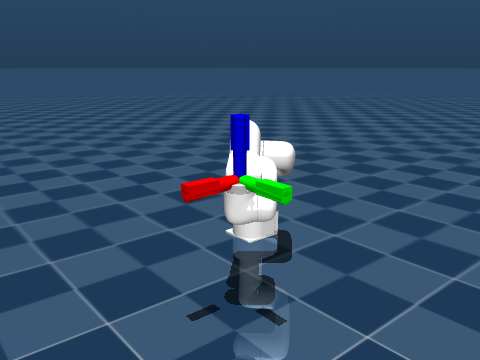

In [36]:
# Visualise the joint poses found by IK for the initial target pose
x, _ = minimize.least_squares(x0, ik, bounds, jacobian=ik_jac,
                              verbose=0)

# Update and visualize
data.qpos = x
mujoco.mj_kinematics(model, data)
mujoco.mj_camlight(model, data)
camera.distance = 1
camera.lookat = data.site('attachment_site').xpos
renderer.update_scene(data, camera, voption)
media.show_image(renderer.render())

In [153]:
# Functions for generating waypoints for test motions

def pose(time, speed=1):
  """
  Rotate around the origin, move up and down, rotate the end effector
  Args:
    time: time in seconds at which to calculate the pose
    speed: a factor by which to speed up the motion (or slow it down)
  """
  pos = (0.4 * np.sin(speed*time),
         0.4 * np.cos(speed*time),
         0.3 + 0.2 * np.sin(3 * speed*time))
  quat = np.array((1.0, np.sin(2 * speed * time), np.sin(speed*time), 0))
  quat /= np.linalg.norm(quat)
  return pos, quat

def pose_faceout(time, speed=1, init_quat=np.array((np.sqrt(2)/2, 0, np.sqrt(2)/2, 0))):
  """
  Rotate around the origin, move up and down, keep end effector facing outwards
  Args:
    time: time in seconds at which to calculate the pose
    speed: a factor by which to speed up the motion (or slow it down)
    init_quat: an initial rotation. The default gets z of the end effector facing outwards
  """

  pos = (0.4 * np.sin(speed*time),
         0.4 * np.cos(speed*time),
         0.35 + 0.1 * np.sin(3 * speed*time))
  # Angle around z axis
  theta = np.arctan2(pos[1], pos[0])
  # Convert to quaternion
  quat = np.array((np.cos(theta/2), 0, 0, np.sin(theta/2)))
  quat /= np.linalg.norm(quat)

  res_quat = np.zeros(4)
  mujoco.mju_mulQuat(res_quat, quat, init_quat)

  return pos, res_quat


In [267]:
# Render a video of the generated target path in mujoco

DURATION = 5          # seconds
FRAMERATE = 60        # Hz

# Reset the camera, make the arm point straight up.
camera.distance = 1.5
camera.elevation = -15
camera.azimuth = -130
camera.lookat = (0, 0, 0.3)
mujoco.mj_resetData(model, data)

frames = []
while data.time < DURATION:
  # Move the target
  pos, quat = pose_faceout(data.time)
  id = model.body('target').mocapid
  data.mocap_pos[id] = pos
  data.mocap_quat[id] = quat

  # mujoco.mj_camlight(model, data)
  mujoco.mj_step(model, data)
  mujoco.mj_kinematics(model, data)

  if len(frames) < data.time * FRAMERATE:
    renderer.update_scene(data, camera, voption)
    frames.append(renderer.render())


media.show_video(frames)

In [492]:
# Now solve for the joint angles at each pose, move the arm, and visualise the solution

DURATION = 5          # seconds
FRAMERATE = 60        # Hz
frames = []
x = x0
mujoco.mj_resetData(model, data)
data.qpos = x0

while data.time < DURATION:
  # Move the target
  # pos, quat = pose(data.time, speed=1)
  pos, quat = pose_faceout(data.time, speed=1)

  x_prev = x.copy()

  # Define IK problem
  ik_target = lambda x: ik(x, pos=pos, quat=quat,
                           reg_target=x_prev, radius=0.5, reg=.1)
  jac_target = lambda x, r: ik_jac(x, r, pos=pos, quat=quat)

  x, _ = minimize.least_squares(x, ik_target, bounds,
                                jacobian=jac_target,
                                verbose=0)

  # mujoco.mj_camlight(model, data)
  mujoco.mj_step(model, data)
  mujoco.mj_kinematics(model, data)

  if len(frames) < data.time * FRAMERATE:
    renderer.update_scene(data, camera, voption)
    frames.append(renderer.render())

media.show_video(frames, loop=False)

## Utils
Some useful functions for interacting with the xArm. It takes poses with euler angles or axis angle (no quaternions), so these are for converting between the two.

In [208]:
def quaternion_to_axis_angle(quat):
  """
  Converts a quaternion to axis-angle representation.

  Args:
    quat: A 4-element quaternion (w, x, y, z) or np.quaternion.

  Returns:
    A tuple containing the axis (a 3-element vector) and the angle (in radians).
  """

  # Extract the scalar and vector components of the quaternion
  if isinstance(quat, np.quaternion):
    w = quat.w
    x = quat.x
    y = quat.y
    z = quat.z
  else:
    w = quat[0]
    x = quat[1]
    y = quat[2]
    z = quat[3]

  # Calculate the angle
  angle = 2 * np.arccos(w)

  # Calculate the axis
  if angle == 0:
    axis = np.array([0, 0, 0])  # Zero vector if angle is zero
  else:
    axis = np.array([x, y, z]) * angle / np.linalg.norm(np.array([x, y, z]))

  return axis

In [505]:
def solve_ik(pos, quat, x0):
  """
  Solve for an end effector pose, return joint angles
  """
  if isinstance(quat, np.quaternion):
    quat = quaternion.as_float_array(quat)

  ik_target = lambda x: ik(x, pos=pos, quat=quat,
                          reg_target=x0, radius=0.2, reg=.1)
  # ik_target = lambda x: ik(x, pos=pos, quat=quat, radius=0.05, reg=.1)
  jac_target = lambda x, r: ik_jac(x, r, pos=pos, quat=quat)
  x, _ = minimize.least_squares(x0, ik_target, bounds,
                              jacobian=jac_target,
                              verbose=0)
  return x


def render_state(x, show=True):
  """
  Render arm position given joint angles, and optionally show
  """
  data.qpos = x

  mujoco.mj_kinematics(model, data)

  camera.lookat = data.site('attachment_site').xpos
  renderer.update_scene(data, camera, voption)
  pixels = renderer.render()
  if show:
    media.show_image(pixels)
  return pixels

def plot_pose(pos, quat, x0, show=True):
  """
  Solve for an end effector pose, render, and optionally show
  """
  x = solve_ik(pos, quat, x0)
  pixels = render_state(x, show=show)
  return x, pixels

def mujoco_to_xarm_pose(pos, quat):
  """
  Convert from position (in m) and quaternion to xarm axis-angle pose [x (mm), y (mm), z (mm), ax, ay, az]
  """
  pos_mm = np.array(pos)*1e3
  aang = quaternion_to_axis_angle(quat)
  return list(pos_mm) + list(aang)

def xarm_to_mujoco_pose(pos_aang):
  """
  Convert from xarm axis-angle pose [x (mm), y (mm), z (mm), ax, ay, az] to position (in m) and quaternion
  """
  angle = np.linalg.norm(pos_aang[3:])
  axis = pos_aang[3:]/angle

  quat = np.zeros(4)
  mujoco.mju_axisAngle2Quat(quat, axis, angle)

  pos = np.array(pos_aang)[:3]/1000.

  return pos, quat

# Check that the conversion functions are legit by converting back and forth
pos, quat = pose_faceout(0)
pose_xarm = mujoco_to_xarm_pose(pos, quat)
pos_recomp, quat_recomp = xarm_to_mujoco_pose(pose_xarm)
print(f"Orig: {pos}, {quat} should equal recomputed: {pos_recomp} {quat_recomp}")
print(f"Xarm axis angle: {pose_xarm}")

# ompare the np arrays
assert(np.allclose(pos, pos_recomp))
assert(np.allclose(quat, quat_recomp))
print("Success")

Orig: (0.0, 0.4, 0.35), [ 0.5 -0.5  0.5  0.5] should equal recomputed: [0.   0.4  0.35] [ 0.5 -0.5  0.5  0.5]
Xarm axis angle: [0.0, 400.0, 350.0, -1.209199576156145, 1.2091995761561454, 1.209199576156145]
Success


## Real life
Now let's try to make the real arm do this motion! We'll start with position control as we already have the poses.

XArm control modes: \
0: position control mode \
1: servo motion mode \
2: joint teaching mode \
3: cartesian teaching mode (invalid) \
4: joint velocity control mode \
5: cartesian velocity control mode \
6: joint online trajectory planning mode  \
7: cartesian online trajectory planning mode

In [ ]:
from xarm.wrapper import XArmAPI
import time
import collections
ip = "192.168.1.185"

ROBOT_IP: 192.168.1.185, VERSION: v1.12.2, PROTOCOL: V1, DETAIL: 6,9,LI1006,DL1000,v1.12.2, TYPE1300: [0, 0]
change protocol identifier to 3



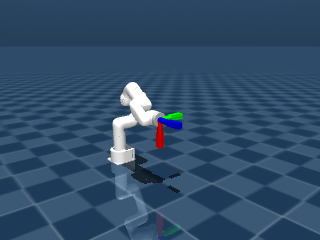

Current pos: [-0.    0.4   0.35], quat: [ 0.5 -0.5  0.5  0.5]
ControllerWarning, code: 12



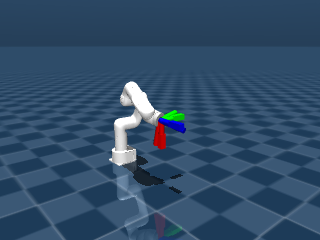

Init pos: (0.0, 0.4, 0.35), quat: [ 0.5 -0.5  0.5  0.5]


In [586]:
# Visualise current arm pose, and the new pose to get to
arm = XArmAPI(ip, is_radian=True)

x0 = model.key(0).qpos

# Apparently the reading is only valid if the code returned is 0
code, curr_xarm_aa_pose = arm.get_position_aa()
code2, state = arm.get_servo_angle()
if any((code, code2)):
  print(f"Invalid pos reading, codes: {(code, code2)}") 

curr_pos, curr_quat = xarm_to_mujoco_pose(curr_xarm_aa_pose)

# Visualise current pose in MuJoCo to compare to real life
render_state(state[:6]) # can also be used to ensure consistency with frames of reference etc.
# plot_pose(curr_pos, curr_quat, x0)
print(f"Current pos: {curr_pos}, quat: {curr_quat}")

# Visualise the pose we need to get to to start the motion
init_pos, init_quat = pose_faceout(0)
x = plot_pose(init_pos, init_quat, x0)
print(f"Init pos: {init_pos}, quat: {init_quat}")


### Getting to the start position
The first challenge comes before even executing the spinning motion - we need to get to the starting pose. You can either teleop the robot arm to the right place, or here, we create a simple screw trajectory to get it there.

This first cell shows how we can interpolate between two quaternions to get smoothly from one orientation to another, at the same position. You can then interpolate the position linearly, and have your robot at the right pose.

The approach we will take is to interpolate position and orientation simultaneously via a screw trajectory, which applies a constant twist to get from the start to the end pose. This creates a more looping motion that is less likely to self collide.

For a primer on the theory, watch/read the [chapter](https://modernrobotics.northwestern.edu/nu-gm-book-resource/9-1-and-9-2-point-to-point-trajectories-part-1-of-2/#department) on trajectory generation from the Modern Robotics textbook by Kevin Lynch, and Frank Park

Interpolation:
quaternion(0.682247476118977, -0.0399232022445659, 0.729678118179553, -0.0226795745500599)
quaternion(0.681581274831319, -0.0919677394467401, 0.725119639623625, 0.0345023032923095)
quaternion(0.676825841789546, -0.143460504740872, 0.716210715470998, 0.0914771802685708)
quaternion(0.668009707806513, -0.19409256086779, 0.703004795921795, 0.147903228507681)
quaternion(0.655185766376164, -0.243560134500182, 0.685581111535244, 0.203441912904968)
quaternion(0.638430956332422, -0.291566438768504, 0.664044197876062, 0.257760022205652)
quaternion(0.617845800245076, -0.337823453870773, 0.638523268340325, 0.310531668147281)
quaternion(0.593553801322097, -0.382053655083245, 0.609171438923593, 0.361440240666946)
quaternion(0.565700702436765, -0.423991677804562, 0.576164809582431, 0.410180307442793)
quaternion(0.534453611725143, -0.46338590964373, 0.539701407700778, 0.45645944637328)
quaternion(0.5, -0.5, 0.5, 0.5)



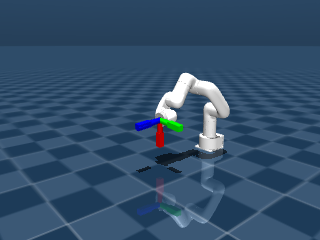
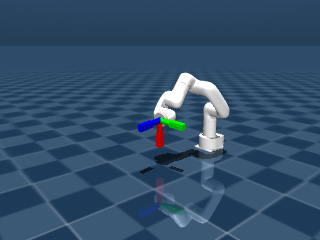
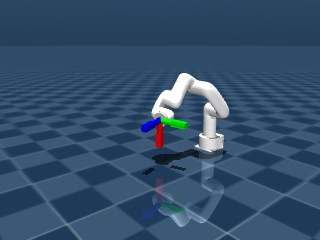
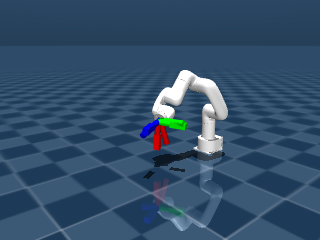
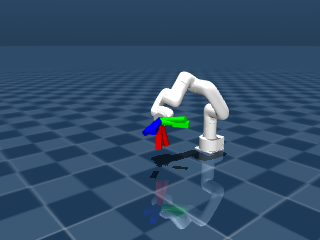
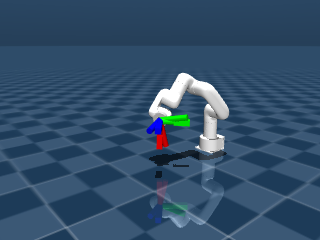
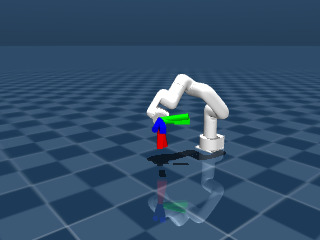
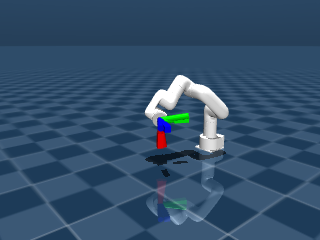
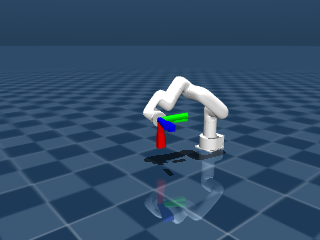
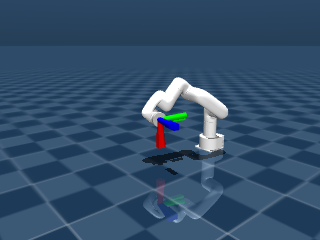
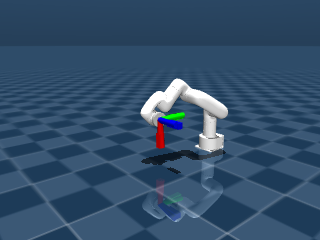

In [298]:
# Arm couldn't deal with end effector being flipped, so we interpolate from current to desired orientation
quat_waypoints = [np.slerp_vectorized(quaternion.as_quat_array(curr_quat), quaternion.as_quat_array(init_quat), x) for x in np.linspace(0, 1, 11)]

print("Interpolation:")
[print(quat) for quat in quat_waypoints]
frames = []
for quat in quat_waypoints:
  _, pixels = plot_pose(curr_pos, quat, x0, show=False)
  frames.append(pixels)

  # Uncomment for motion
  # next_pose = mujoco_to_xarm_pose(curr_pos, quat)
  # print(f"Move from {arm.get_position_aa()[1]} to {next_pose} ")
  # arm.set_position_aa(next_pose, speed=100, radius=None, wait=True)

media.show_images(frames)

### Time scaling
A time scaling _s(t)_ maps a path (a curve to be followed) to a trajectory (a path/poses as a function of time). A short time obviously means that the robot is moves at higher velocity.

A linear time scaling would result in jerky motion at the start and end as the robot would have to instantaneously jump to the initial velocity. Instead, a third order polynomial allows us to ramp the velocity up and down and the start and end smoothly if we pick appropriate coefficients. A 5th order polynomial allows for a smooth ramp of acceleration as well. 

_s(t)_ is in the range [0, 1]

In [406]:
def s(t, end_time):
  """
  Calculate a third order polynomial time scaling s
  s = a0 + a1*t + a2*t^2 + a3*t^3
  where
  s = 0 at t=0 and s=end_time at t=end_time
  sdot is 0 at t=0 and t=end_time

  Vectorised implementation allows caluclation of multiple t values simultaneously

  Args:
    t: a time or array of times for which to calculate s
    end_time: the duration of the trajectory, shorter means faster

  Returns:
    s: s value
    s_1: first derivative of s
    s_2: second derivative of s
  """
  t = np.array(t)
  assert(np.all(t >= 0) and np.all(t <= end_time))
  a0 = 0
  a1 = 0
  a2 = 3/end_time**2
  a3 = -2/end_time**3

  # Constants for s, sdot, sddot
  A = np.array([[a0, a1, a2, a3],
                [a1, 2*a2, 3*a3, 0],
                [2*a2, 6*a3, 0, 0]])

  # Form a matrix of
  # [1,     1,     ...]
  # [t0,    t1,    ...]
  # [t0**2, t1**2, ...]
  # [t0**3, t1**3, ...]
  x = np.ones(t.size)
  for i in range(1, 4):
      x = np.vstack((x, t**i))

  assert(x.shape == (4, t.size))

  s = A @ x
  s_0 = s[0, :]
  s_1 = s[1, :]
  s_2 = s[2, :]
  return s_0, s_1, s_2


(array([1.]), array([0.]), array([-0.66666667]))

Now let's plot the time scaling so you can see its properties

Text(0.5, 1.0, 'sddot')

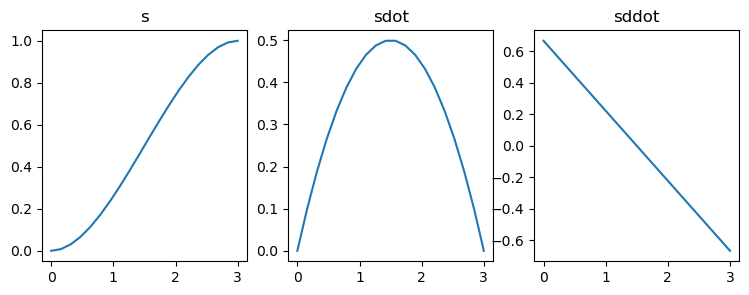

In [334]:
import matplotlib.pyplot as plt
%matplotlib inline

end_time = 3
t = np.linspace(0, end_time, 20)

s_0, s_1, s_2 = s(t, end_time)

fig = plt.figure(figsize=(9, 3))
ax = plt.subplot(1, 3, 1)
ax.plot(t,s_0)
ax.set_title("s")

ax = plt.subplot(1, 3, 2)
ax.plot(t,s_1)
ax.set_title("sdot")

ax = plt.subplot(1, 3, 3)
ax.plot(t,s_2)
ax.set_title("sddot")


Notice the parabolic sdot (velocity) curve starting and ending at rest. Whereas the acceleration is discontinuous at start and end - which is fine, but if you want the acceleration to smoothly ramp, try a 5th order polynomial.

The next cell defines some functions for turning position and orientation into a homogeneous transform matrix for doing pose interpolation.

In [427]:
def get_tf_matrix(pos, quat):
  if isinstance(quat, np.quaternion):
    quat = quaternion.as_float_array(quat)

  pos = np.reshape(np.atleast_2d(pos), (3, 1))
  R = np.zeros(9)
  mujoco.mju_quat2Mat(R, quat)
  R = np.reshape(R, (3, 3))
  T = np.hstack((R, pos))
  T = np.vstack((T, [0, 0, 0, 1]))
  return T

def tf_matrix_to_pose_quat(T):
  R = T[:3, :3].reshape((9, 1))
  pos = list(T[:3, 3])
  quat = np.zeros(4)
  mujoco.mju_mat2Quat(quat, R)
  return pos, quat

def invert_tf_matrix(T):
  R = T[:3, :3]
  t = T[:3, 3]
  T_inv = np.eye(4)
  T_inv[:3, :3] = R.T
  T_inv[:3, 3] = -R.T @ t
  
  return T_inv

# TODO: set pos, quat test values

Tinit = get_tf_matrix(init_pos, init_quat)
Tinit_inv = invert_tf_matrix(Tinit)
Tinit_recomp = invert_tf_matrix(Tinit_inv)
print(f"Tinit:\n{Tinit}\nTinit_recomp:\n{Tinit_recomp}")

assert(np.allclose(Tinit, Tinit_recomp))

pos, quat = tf_matrix_to_pose_quat(Tinit)
Tinit_recomp = get_tf_matrix(pos, quat)

print(f"Tinit:\n{Tinit}\nTinit_recomp:\n{Tinit_recomp}")
assert(np.allclose(Tinit, Tinit_recomp))


Tinit:
[[ 0.00000000e+00 -1.00000000e+00  2.22044605e-16  0.00000000e+00]
 [ 0.00000000e+00  2.22044605e-16  1.00000000e+00  4.00000000e-01]
 [-1.00000000e+00  0.00000000e+00  0.00000000e+00  3.50000000e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Tinit_recomp:
[[ 0.00000000e+00 -1.00000000e+00  2.22044605e-16  0.00000000e+00]
 [ 0.00000000e+00  2.22044605e-16  1.00000000e+00  4.00000000e-01]
 [-1.00000000e+00  0.00000000e+00  0.00000000e+00  3.50000000e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Tinit:
[[ 0.00000000e+00 -1.00000000e+00  2.22044605e-16  0.00000000e+00]
 [ 0.00000000e+00  2.22044605e-16  1.00000000e+00  4.00000000e-01]
 [-1.00000000e+00  0.00000000e+00  0.00000000e+00  3.50000000e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Tinit_recomp:
[[-2.22044605e-16 -1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.22044605e-16  0.00000000e+00  1.00000000e+00  4.00000000e-01]
 [-1.00000000e+00

In [428]:
print(pos, quat)
Tinit = get_tf_matrix(init_pos, init_quat)
Tcurr = get_tf_matrix(curr_pos, curr_quat)
print(Tinit)
print(Tcurr)

[0.0, 0.4, 0.35] [ 0.5 -0.5  0.5  0.5]
[[ 0.00000000e+00 -1.00000000e+00  2.22044605e-16  0.00000000e+00]
 [ 0.00000000e+00  2.22044605e-16  1.00000000e+00  4.00000000e-01]
 [-1.00000000e+00  0.00000000e+00  0.00000000e+00  3.50000000e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[-0.06588904 -0.02731601  0.99745299  0.3975546 ]
 [-0.08920834  0.99578355  0.02137743  0.00140562]
 [-0.99383123 -0.08757259 -0.06804804  0.24339729]
 [ 0.          0.          0.          1.        ]]


Here is our screw interpolation function, which calculates the desired pose at each time

In [587]:
from scipy.linalg import logm, expm
def screw_interp(T_start, T_end, t, end_time):
  """ 
  Screw interpolation calculates a constant twist to get from the start pose to the end pose in the given time.
  This function calculates the pose at a given time t along the trajectory, using our time scaling s(t) from before.
  Args:
    T_start: start pose, as a 4x4 transform matrix
    T_end: end pose, as a 4x4 transform matrix
    t: the time at which to s
  """
  assert(t >= 0 and t <= end_time)
  return T_start @ expm(logm(invert_tf_matrix(T_start)@T_end)*s(t, end_time)[0])

# Tests
# TODO: set test values
assert(np.allclose(screw_interp(Tinit, Tcurr, 0, 3), Tinit))

print(f"End interp:\n{screw_interp(Tinit, Tcurr, 3, 3)}\nEnd pose:\n{Tcurr}")
# np.isclose(screw_interp(Tinit, Tcurr, 3, 3), Tcurr)
assert(np.allclose(screw_interp(Tinit, Tcurr, 3, 3), Tcurr))
    

End interp:
[[ 0.001  0.408  0.913  0.364]
 [-0.     0.913 -0.408 -0.163]
 [-1.     0.     0.001  0.319]
 [ 0.     0.     0.     1.   ]]
End pose:
[[ 0.001  0.408  0.913  0.364]
 [-0.     0.913 -0.408 -0.163]
 [-1.     0.     0.001  0.319]
 [ 0.     0.     0.     1.   ]]


Plot the interpolated poses in Mujoco to see how the trajectory will look

Interpolation:
[[-0.001 -0.237  0.972  0.175]
 [ 0.     0.972  0.237  0.015]
 [-1.     0.    -0.     0.382]
 [ 0.     0.     0.     1.   ]]
[[-0.    -0.273  0.962  0.178]
 [ 0.     0.962  0.273  0.027]
 [-1.     0.    -0.     0.381]
 [ 0.     0.     0.     1.   ]]
[[-0.    -0.369  0.93   0.183]
 [-0.     0.93   0.369  0.061]
 [-1.     0.    -0.     0.378]
 [ 0.     0.     0.     1.   ]]
[[-0.    -0.503  0.864  0.184]
 [-0.     0.864  0.503  0.112]
 [-1.     0.    -0.     0.375]
 [ 0.     0.     0.     1.   ]]
[[-0.    -0.65   0.76   0.176]
 [-0.     0.76   0.65   0.174]
 [-1.     0.    -0.     0.371]
 [ 0.     0.     0.     1.   ]]
[[-0.    -0.786  0.618  0.154]
 [-0.     0.618  0.786  0.238]
 [-1.     0.    -0.     0.366]
 [ 0.     0.     0.     1.   ]]
[[-0.    -0.892  0.452  0.12 ]
 [-0.     0.452  0.892  0.296]
 [-1.     0.    -0.     0.361]
 [ 0.     0.     0.     1.   ]]
[[-0.    -0.959  0.284  0.08 ]
 [-0.     0.284  0.959  0.343]
 [-1.     0.    -0.     0.357]
 [ 0.     0.     


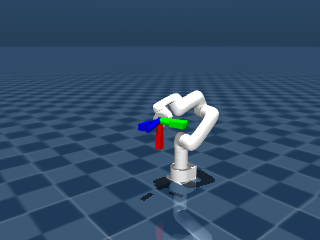
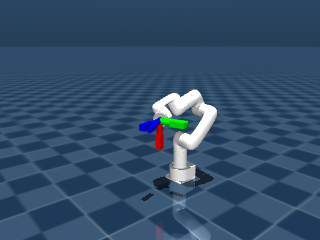
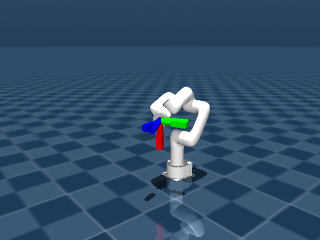
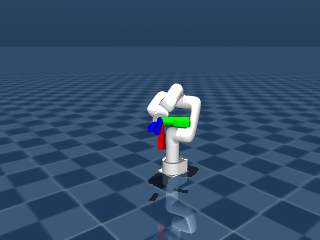
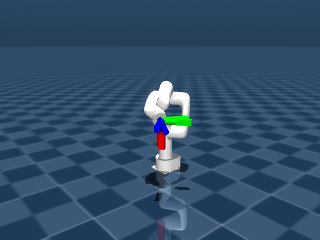
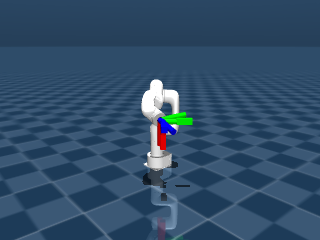
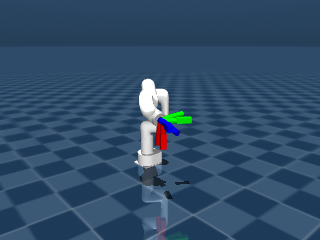
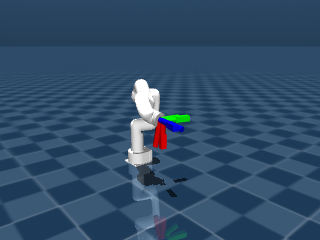
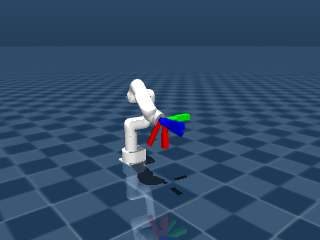
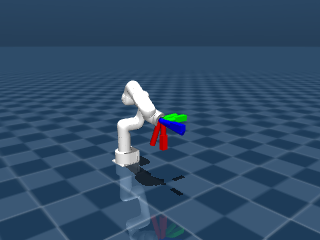
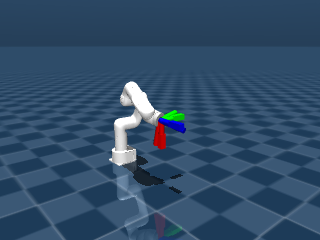

In [534]:
# This works well, but doesn't take into account joint limits
Tcurr = get_tf_matrix(*xarm_to_mujoco_pose(arm.get_position_aa()[1]))
Tinit = get_tf_matrix(*pose_faceout(0))
screw_waypoints = [screw_interp(Tcurr, Tinit, t, end_time) for t in np.linspace(0, end_time, 11)]

print("Interpolation:")
[print(T) for T in screw_waypoints]
print("Tcurr:")
print(Tcurr)
frames = []
for T in screw_waypoints:
  _, pixels = plot_pose(*tf_matrix_to_pose_quat(T), x0, show=False)
  frames.append(pixels)

media.show_images(frames)
media.show_video(frames, loop=False, fps=len(frames)/end_time)


Now let's run it on the robot!

If you get any errors, run arm.reset() to clear them

In [579]:
# Get the arm ready for motion
arm = XArmAPI(ip, is_radian=True)
arm.motion_enable(enable=True)
arm.set_mode(0)
arm.set_state(state=0)

init_xarm_aa_pose = mujoco_to_xarm_pose(init_pos, init_quat)

print(f"Curr pos: {curr_xarm_aa_pose}")
print(f"Goal pos: {init_xarm_aa_pose}")

ROBOT_IP: 192.168.1.185, VERSION: v1.12.2, PROTOCOL: V1, DETAIL: 6,9,LI1006,DL1000,v1.12.2, TYPE1300: [0, 0]
change protocol identifier to 3
[motion_enable], xArm is not ready to move
[set_state], xArm is ready to move
Curr pos: [85.566216, 0.001938, 153.490952, -3.139547, -0.107526, 0.008532]
Goal pos: [0.0, 400.0, 350.0, -1.209199576156145, 1.2091995761561454, 1.209199576156145]


In [583]:
arm.set_state(state=0)
print("ready")

curr_pos, curr_quat = xarm_to_mujoco_pose(arm.get_position_aa()[1])
Tcurr = get_tf_matrix(curr_pos, curr_quat)
Tinit = get_tf_matrix(*pose_faceout(0))

end_time = 3

screw_waypoints = [screw_interp(Tcurr, Tinit, t, end_time) for t in np.linspace(0, end_time, 11)]

for T in screw_waypoints:
  # time.sleep(1)
  next_pose = mujoco_to_xarm_pose(*tf_matrix_to_pose_quat(T))
  print(f"Move from {arm.get_position_aa()[1]} to {next_pose} ")
  arm.set_position_aa(next_pose, speed=100, radius=None, wait=True)

ready
Move from [364.13443, -162.789673, 319.157135, 0.32977, 1.544409, -0.33012] to [364.13443, -162.789673, 319.157135, 0.32976999999999995, 1.5444089999999997, -0.33012] 
Move from [364.13443, -162.789673, 319.157135, 0.32977, 1.544409, -0.33012] to [372.67415299438557, -142.22436177031247, 320.02485984267037, 0.28613867852200253, 1.5507023841817196, -0.2864817057205499] 
Move from [372.674164, -142.224365, 320.024872, 0.286139, 1.550702, -0.286482] to [389.94473974671155, -84.3548269368035, 322.3768611786347, 0.16752318721018755, 1.5632820314263205, -0.1678464123805277] 
Move from [389.944733, -84.354828, 322.376862, 0.167523, 1.563282, -0.167846] to [399.0697327652458, 4.074652570869391, 325.835359286568, -0.0075628875288391755, 1.5698801381822896, 0.007271127223271426] 
Move from [399.069733, 4.074653, 325.835358, -0.007563, 1.56988, 0.007271] to [383.58141211136245, 110.79960189804342, 330.02574245654876, -0.2201119474636778, 1.558802891363389, 0.21986194902149855] 
Move from [3

### Run the spinning motion

Now that we're at the start, let's spin! This first run uses the _set_position_aa_ API call to simply set the pose in cartesian coordinates and let the arm do the inverse kinematics

In [576]:
arm.set_state(state=0)

arm.set_position_aa(init_xarm_aa_pose, speed=200, radius=0, wait=True)

print("ready")

DURATION = 30
RATE = 5 

t = 0
buff_len = int(RATE / 2)
tdiff = collections.deque(maxlen=buff_len)

start_time = time.time()

while time.time() < start_time + DURATION:
    if (arm.has_error):
      print(f"Exiting, error {arm.error_code}")
      break
    
    loop_start = time.time()
    t = loop_start - start_time

    # Print the rate every 0.5s to make sure we're keeping up
    if (len(tdiff) > 0) and int(t*2) != int(t_prev*2):
      print(f"Rate: {1.0/np.array(tdiff).mean()}")

    pos, quat = pose_faceout(-t, speed=0.2)
    
    arm.set_position_aa(mujoco_to_xarm_pose(pos, quat), speed=200, radius=None, wait=True)
    sleep_time = loop_start + 1.0/RATE - time.time()
    if sleep_time > 0:
      time.sleep(sleep_time)
    
    tdiff.append(t - t_prev)
    t_prev = t


[SDK][ERROR][2024-06-14 17:57:35][base.py:380] - - wait_move, xarm is stop, state=4
ready
[SDK][ERROR][2024-06-14 17:57:35][base.py:380] - - API -> set_position_aa -> code=1, pos=[-0.019989013663555395, 399.9999995005492, 349.9850082398022, -1.2092363758361826, 1.209175948739895, 1.2092363758361826], velo=200.0, acc=2000
Exiting, error 24


#### Issues with cartesian pose control
- The arm sometimes can't reset as it hits the joint limits when it tries to return, especially after doing a full rotation. Need to fully unwind
- It sometimes can't reset to the start because it linearly interpolates and self collides
- It initialises to angles that put it in a bad position for the trajectory
- Movement is stepwise, not smooth, arm doesn't keep up with instructions

Time for direct joint angle control!

In [575]:
# Use this to reset any errors

[motion_enable], xArm is not ready to move
[set_state], xArm is ready to move


In [582]:
arm.set_state(state=0)

init_x = solve_ik(*pose_faceout(0), model.key(0).qpos)
arm.set_servo_angle(angle=init_x, speed=100, wait=True)

arm.set_state(state=1)
print("ready")

DURATION = 10
RATE = 10 

t = 0
buff_len = int(RATE / 2)
tdiff = collections.deque(maxlen=buff_len)

xprev = init_x
angles = []
start_time = time.time()
while time.time() < start_time + DURATION:
    if (arm.has_error):
      print(f"Exiting, error {arm.error_code}")
      break
    
    loop_start = time.time()
    t = loop_start - start_time

    # Print publish rate every 0.5s
    if (len(tdiff) > 0) and int(t*2) != int(t_prev*2):
      print(f"Rate: {1.0/np.array(tdiff).mean()}")

    pos, quat = pose_faceout(t, speed=0.2)
    x = solve_ik(pos, quat, xprev)
    angles.append(x)
    
    arm.set_servo_angle(angle=x, speed=200, wait=True)
    # render_state(x)
    sleep_time = loop_start + 1.0/RATE - time.time()
    if sleep_time > 0:
      time.sleep(sleep_time)

    tdiff.append(t - t_prev)
    t_prev = t
    xprev = x.copy()
    

ready
Rate: -0.10069852437176621
Rate: -0.21433276910258847
Rate: -0.3428857414587458
Rate: -0.6268088003793936
Rate: 2.1678732275793857
Rate: 2.4325288939012903
Rate: 2.840910260835452
Rate: 2.851084135553311
Rate: 2.868452875227514
Rate: 2.892537270613731
Rate: 2.901627297837164
Rate: 2.906255188127928
Rate: 2.87131590797723
Rate: 2.856607732005595
Rate: 2.864595456100149
Rate: 2.876704361519426
Rate: 2.893989411277985
Rate: 2.8922416723751088
Rate: 2.8994545632268243



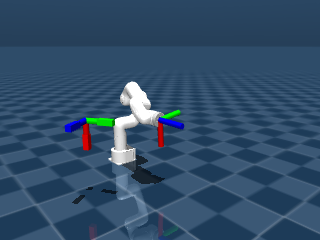
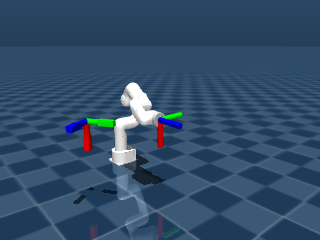
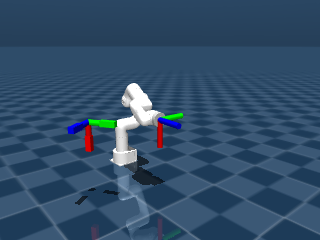
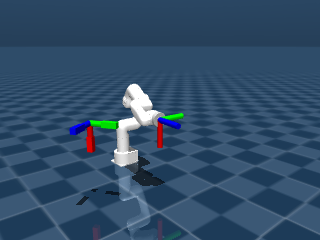
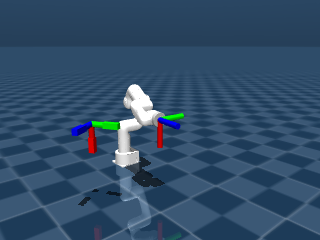
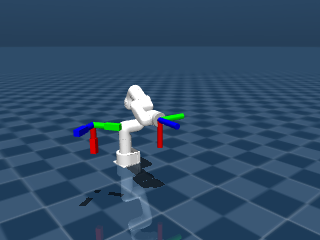
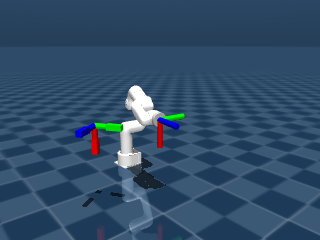
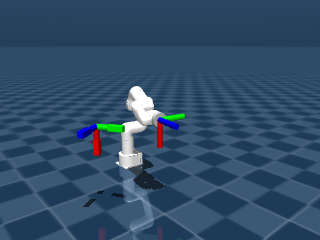
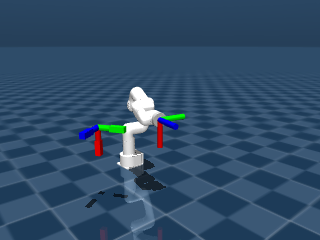
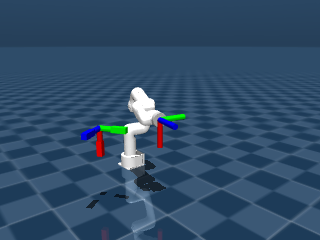
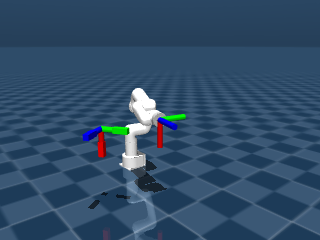
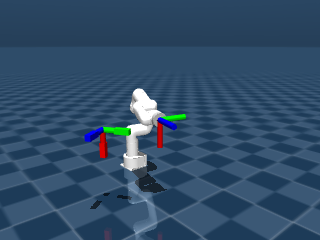
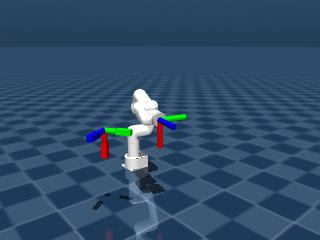
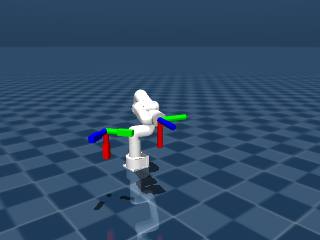
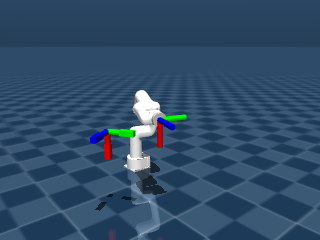
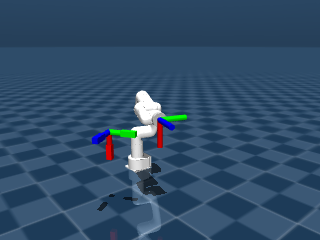
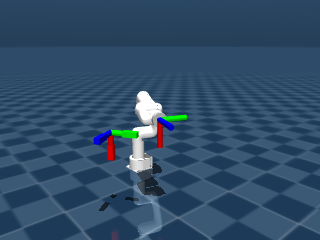
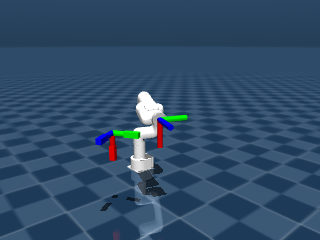
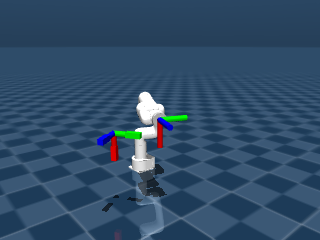
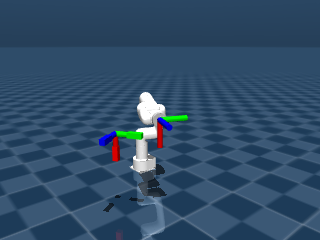
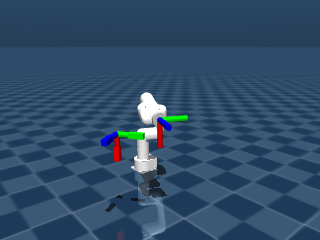
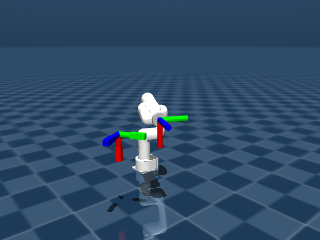
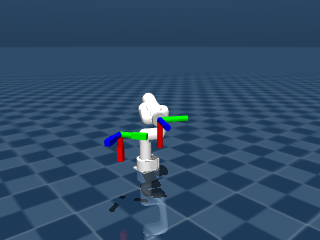
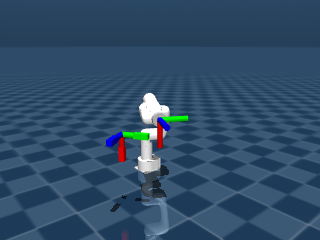
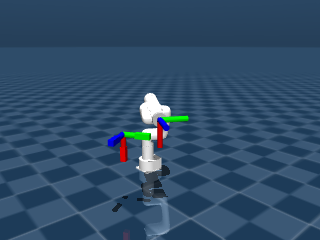
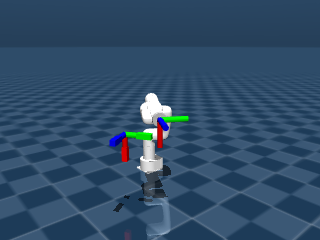
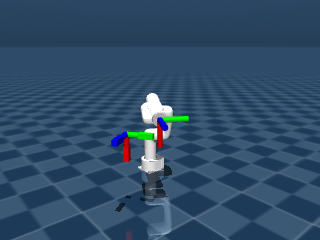
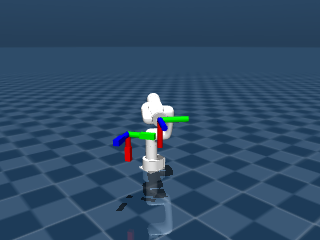
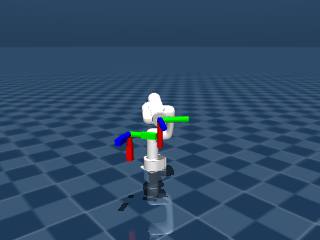
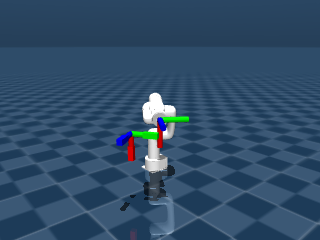
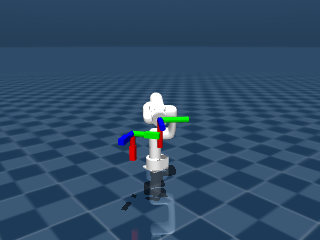
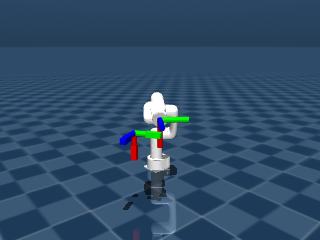
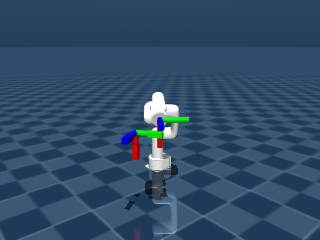
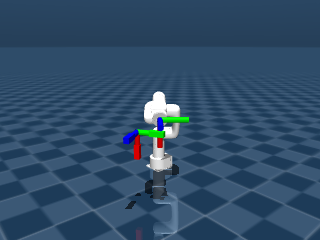
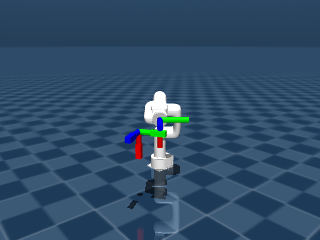
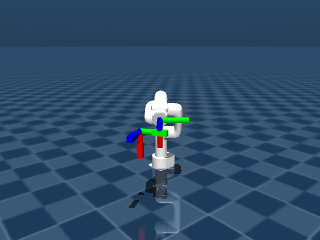
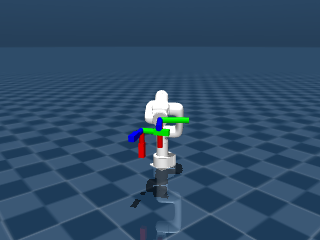
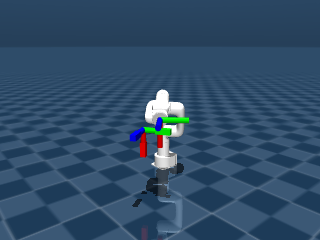
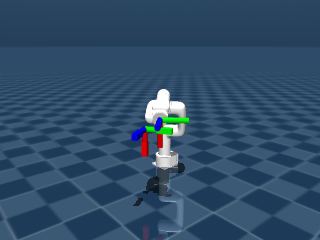
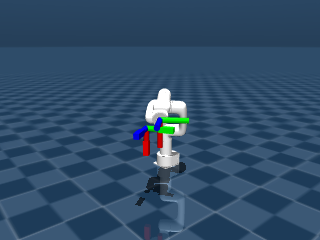
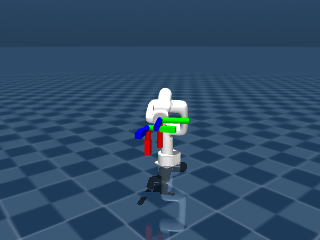
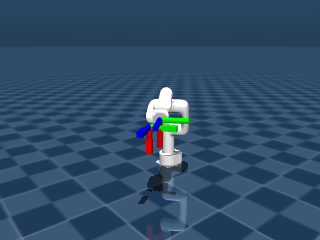
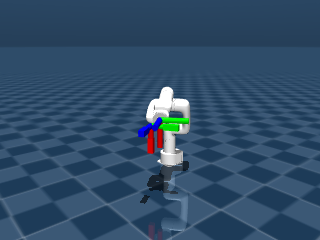
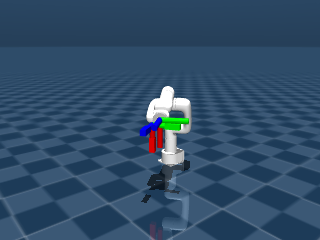
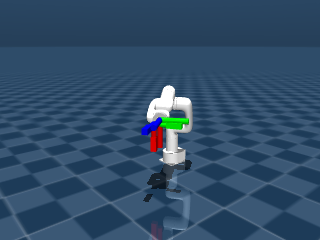
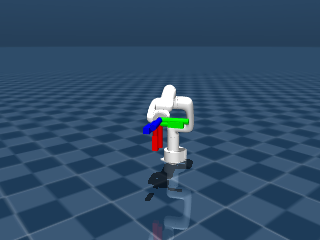
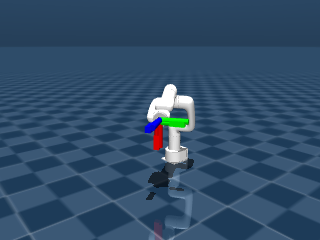
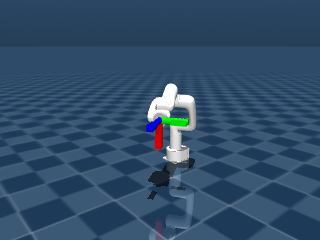
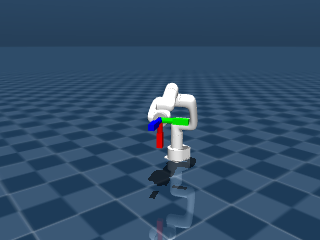

In [522]:
frames = [render_state(x, show=False) for x in angles]
media.show_images(frames)
media.show_video(frames, fps=RATE)

In [545]:
arm.motion_enable(False)

0